In [1]:
%pylab inline
import os
from tqdm.auto import tqdm
import tifffile

Populating the interactive namespace from numpy and matplotlib


In [2]:
import functools
import torch
import torch.nn.functional as F
import numpy as np


class GaussianBlur1D(torch.nn.Module):
    def __init__(self, sigma, sigma_cutoff=None, cutoff=None, eps=1e-10, normalize_weight=True, normalize_border=True):
        if cutoff is None:
            if sigma_cutoff is None:
                sigma_cutoff = 3  # by default, use 3 sigma
            cutoff = int(np.ceil(sigma * sigma_cutoff))
        else:
            assert sigma_cutoff is None
        super(GaussianBlur1D, self).__init__()
        dx = torch.arange(-cutoff, cutoff + 1, dtype=torch.float)
        w = torch.exp(-(dx ** 2) / (2 * sigma ** 2))
        if normalize_weight:
            w /= w.sum()
        self.register_buffer('w', w)
        self.cutoff = cutoff
        self.eps = eps
        self.normalize_border = normalize_border

    @functools.lru_cache(maxsize=8)
    def border_normalizer(self, shape):
        x = torch.ones(1, 1, *shape[2:]).to(self.w.device)
        x = F.conv1d(x, self.w[None, None], padding=self.cutoff)
        x /= max(x.max(), self.eps)
        return x

    def forward(self, x):
        x = F.conv1d(x, self.w[None, None], padding=self.cutoff)
        if self.normalize_border:
            return x / self.border_normalizer(x.shape)
        else:
            return x


class GaussianBlur2D(GaussianBlur1D):
    @functools.lru_cache(maxsize=8)
    def border_normalizer(self, shape):
        x = torch.ones(shape).to(self.w.device)
        x = F.conv2d(x, self.w[None, None, :, None].repeat(shape[1], 1, 1, 1),
                     padding=(self.cutoff, 0), groups=shape[1])
        x = F.conv2d(x, self.w[None, None, None, :].repeat(shape[1], 1, 1, 1),
                     padding=(0, self.cutoff), groups=shape[1])
        x /= max(x.max(), self.eps)
        return x

    def forward(self, x):
        n_channels = x.shape[1]
        self.w = self.w.to(x.device)
        x = F.conv2d(x, self.w[None, None, :, None].repeat(n_channels, 1, 1, 1),
                     padding=(self.cutoff, 0), groups=n_channels)
        x = F.conv2d(x, self.w[None, None, None, :].repeat(n_channels, 1, 1, 1),
                     padding=(0, self.cutoff), groups=n_channels)
        if self.normalize_border:
            return x / self.border_normalizer(x.shape)
        else:
            return x
        
        
def blur(arr, sigma):
    if arr.ndim == 3:
        return GaussianBlur2D(sigma)(torch.from_numpy(arr).float()[None]).cpu().numpy()[0]
    if arr.ndim == 2:
        return GaussianBlur2D(sigma)(torch.from_numpy(arr).float()[None, None]).cpu().numpy()[0, 0]
    assert False, f'{arr.shape}'

## Compute Barrel Corrector from raw images

In [12]:
# Set some paths:
 
misc_folder = '../misc/'
assert os.path.exists(misc_folder)

average_dir = '../misc/plate_stats/'

# FIXME: set this to a list of paths to the plates from which you want to compute the barrel corrector
# plate_dirs = glob('/export/home/rremme/Datasets/antibodies/covid-data-vibor/*')
plate_dirs = ['/g/kreshuk/data/covid/covid-data-vibor/KnopLab_20201113_133630_500']

offset = 550

### Compute averages and variances for all plates

In [4]:
from batchlib.preprocessing.preprocess import parse_channel_names
from batchlib.outliers.outlier import get_outlier_predicate
from batchlib.util.io import *

In [5]:


def average_over_tiff_directory(directory, normalize_imgs=False):
    """computes the average image of all *.tiff files in the specified directory"""
    class Config:
        misc_folder = misc_folder
        input_folder = directory
    outlier_predicate = get_outlier_predicate(Config)
    total = 0
    n = 0
    perc = []
    for filename in tqdm(list(filter(lambda f: f.endswith('.tiff') and not outlier_predicate(f) == 1,
                                     os.listdir(directory)))):
        img = tifffile.imread(os.path.join(directory, filename)).astype(np.int64)
        if normalize_imgs:
            img -= 550
            img = img.astype(np.float32)
            img /= np.mean(img, axis=(-1, -2), keepdims=True)
        total += img
        n += 1
    return total / n

def average_and_variance_over_tiff_directory(directory):
    """computes the pixelwise average and variance over all *.tiff files in the specified directory"""
    avg = average_over_tiff_directory(directory)
    class Config:
        misc_folder = misc_folder
        input_folder = directory
    outlier_predicate = get_outlier_predicate(Config)
    total = 0
    n = 0
    perc = []
    for filename in tqdm(list(filter(lambda f: f.endswith('.tiff') and not outlier_predicate(f) == 1,
                                     os.listdir(directory)))):
        total += np.abs(avg - tifffile.imread(os.path.join(directory, filename)).astype(np.int64))**2
        n += 1
    return avg, total / n

In [17]:
import traceback
import time

os.makedirs(average_dir, exist_ok=True)

# # this is a hack to get the most recent plates
# def get_days_since_change(file):
#     return (time.time() - os.path.getmtime(file)) / 60 / 60 / 24 
# plate_dirs = list(filter(lambda x: get_days_since_change(x) < 1, plate_dirs))

failed = []
for plate_dir in tqdm(plate_dirs):
    try:
        if plate_dir.endswith(('_IgA', '_IgG')):
            continue
        plate_name = os.path.basename(plate_dir)
        print(plate_name)
        avg, var = average_and_variance_over_tiff_directory(plate_dir)
        channels = parse_channel_names(list(filter(lambda f: f.endswith('.tiff'), os.listdir(plate_dir)))[0])
        result_file = os.path.join(average_dir, plate_name + '.h5')

        # get outlier info 
        class Config:
            misc_folder = misc_folder
            input_folder = plate_dir
        outlier_predicate = get_outlier_predicate(Config)
        n_total = len(list(os.listdir(plate_dir)))
        n_outlier = len(list(filter(lambda f: f.endswith('.tiff') and outlier_predicate(f) == 1, os.listdir(plate_dir))))
        n_non_outlier = n_total - n_outlier

        with open_file(result_file, 'a') as f:
            for i, channel in enumerate(channels):
                if 'average' in f.keys():
                    del f['average']
                write_image(f, f'{channel}/average', avg[i])
                write_image(f, f'{channel}/variance', var[i])
                f[f'{channel}'].attrs['n_total'] = n_total
                f[f'{channel}'].attrs['n_outlier'] = n_outlier
                f[f'{channel}'].attrs['n_non_outlier'] = n_non_outlier
        print(plate_name)

    except Exception:
        failed.append(plate_dir)
        print(traceback.format_exc())

print(f'{len(failed)} plates failed: {failed}')

Did not find outliers for /g/kreshuk/data/covid/covid-data-vibor/KnopLab_20201113_133630_500. Outlier detection will be skipped


KnopLab_20201113_133630_500


Did not find outliers for /g/kreshuk/data/covid/covid-data-vibor/KnopLab_20201113_133630_500. Outlier detection will be skipped


Did not find outliers for /g/kreshuk/data/covid/covid-data-vibor/KnopLab_20201113_133630_500. Outlier detection will be skipped



KnopLab_20201113_133630_500

0 plates failed: []


### Group averages by image shape and select the one we want to use: (1024, 1024)

In [18]:
from collections import defaultdict

avgs_by_shape = defaultdict(lambda: defaultdict(dict))

for file in tqdm(glob(os.path.join(average_dir, '*.h5'))):
    plate_name = os.path.basename(file)[:-3]
    print(plate_name)
    with open_file(file, 'r') as f:
        for i, channel in enumerate(f.keys()):
            img = read_image(f, f'{channel}/average')
            extra_info = dict(f[channel].attrs)
            extra_info['plate'] = plate_name
            avgs_by_shape[img.shape][channel][plate_name] = (img, extra_info)
            #f[f'{channel}'].attrs['n_total'] = n_total
            #f[f'{channel}'].attrs['n_outlier'] = n_outlier
            #f[f'{channel}'].attrs['n_non_outlier'] = n_non_outlier

KnopLab_20201113_133630_500



In [19]:
print('available shapes: ', avgs_by_shape.keys())
avgs_by_channel = avgs_by_shape[(1024, 1024)]

available shapes:  dict_keys([(1024, 1024)])


In [20]:
meta_avg_dict = dict()  # maps channels to blurred average of averages
for channel, avgs_by_plate in avgs_by_channel.items():
    print(channel)
    if len(avgs_by_plate) == 0:
        print('nope..')
        continue
    stacked_avgs = np.stack(list(map(lambda x: x[0], avgs_by_plate.values())))
    stacked_avgs -= offset
    stacked_avgs /= stacked_avgs.mean(axis=(-1, -2), keepdims=True)
    weights = np.array(list(map(lambda x: x[1]['n_non_outlier'], avgs_by_plate.values()))).astype(np.float32)
    weights /= np.sum(weights)
    avg_of_avgs = (stacked_avgs * weights[:, None, None]).sum(0)
    meta_avg_dict[channel] = blur(avg_of_avgs, 30) # TODO: sigma=30 is currently hard coded
    #image_interact(meta_avg_dict[channel], colorbar=True, vmin=0, title=channel)

DAPI
DIA
TRITC
WF_Cy5
WF_GFP


### Save the results

In [36]:
# FIXME: adjust the save locations to your liking

out_folder = '/g/kreshuk/pape/Work/covid/batchlib/misc/barrel_correctors/setup2'
out_path = os.path.join(out_folder, 'barrel_corrector_1024x1024_setup2.h5')
with h5py.File(out_path, 'w') as f:
    f.attrs['image_shape'] = [1024, 1024] 
    for key, img in meta_avg_dict.items():
        f.create_dataset(key, data=img, compression='gzip')
        f[key].attrs['offset'] = offset
    
#with h5py.File('barrel_corrector_930x1024_new-microscope.h5', 'w') as f:
#    f.attrs['image_shape'] = [930, 1024] 
#    for key, img in meta_avg_dict.items():
#        f.create_dataset(key, data=img[1024-930:], compression='gzip')
#        f[key].attrs['offset'] = offset

## Test Barrel correction

In [33]:
def barrel_correct(raw, divisor):
    return ((raw.astype('float32') - offset) / divisor).astype('float32') + offset

In [27]:
files = [ff for plate in plate_dirs for ff in glob(os.path.join(plate, '*.tiff'))]
print(len(files))

216


In [31]:
channels = list(meta_avg_dict.keys())

['DAPI', 'DIA', 'TRITC', 'WF_Cy5', 'WF_GFP']


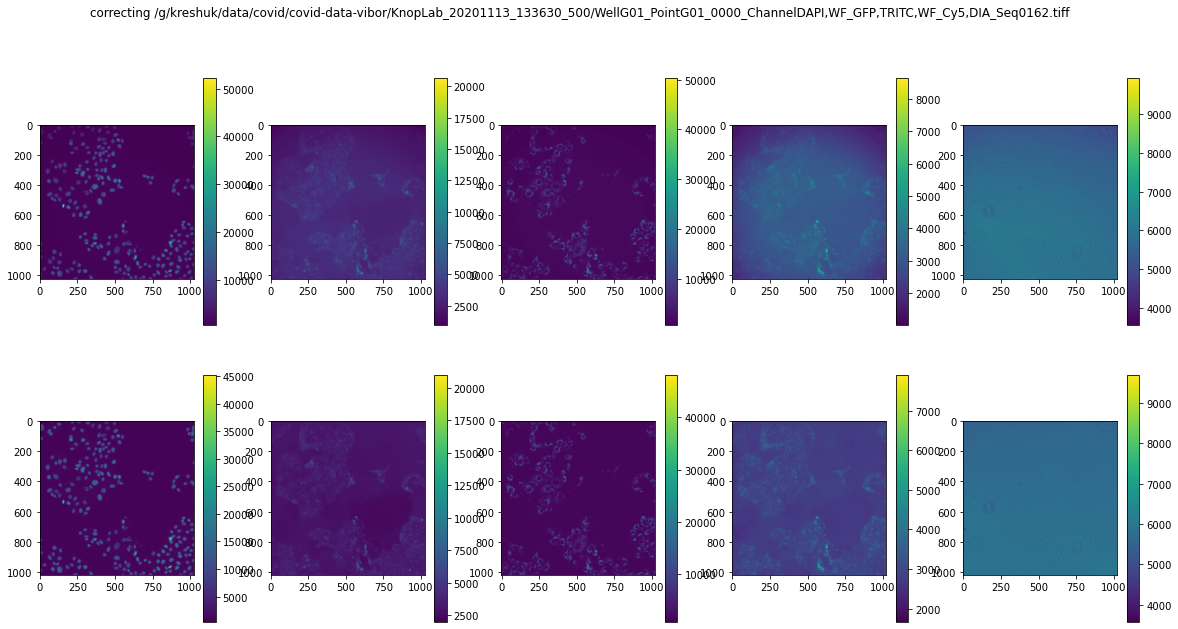

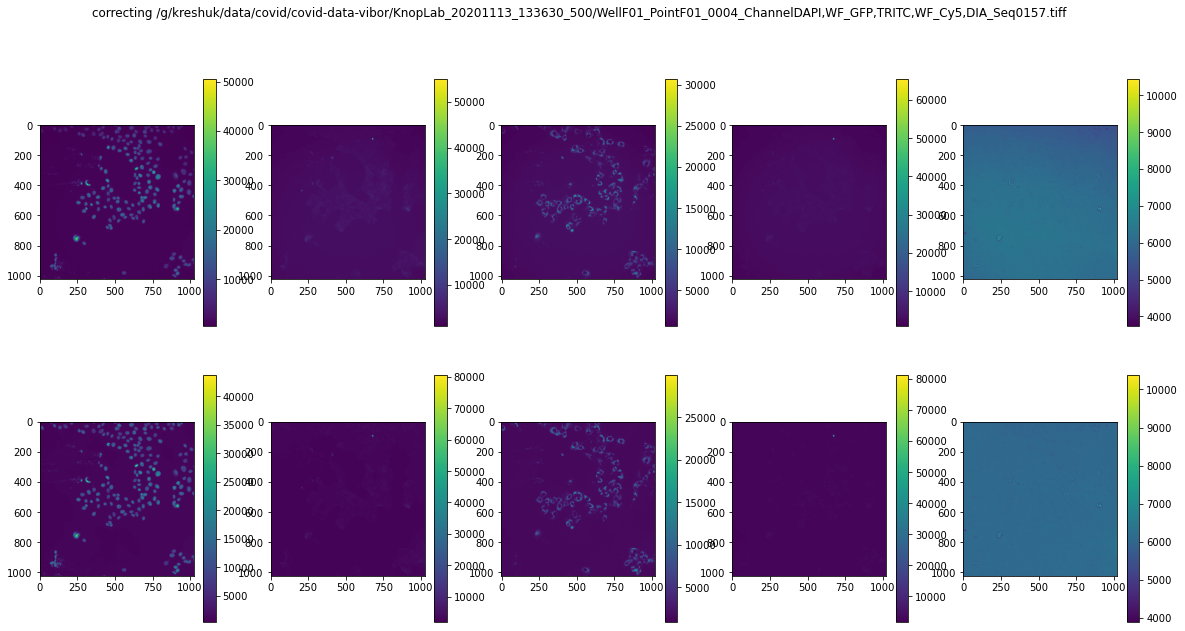

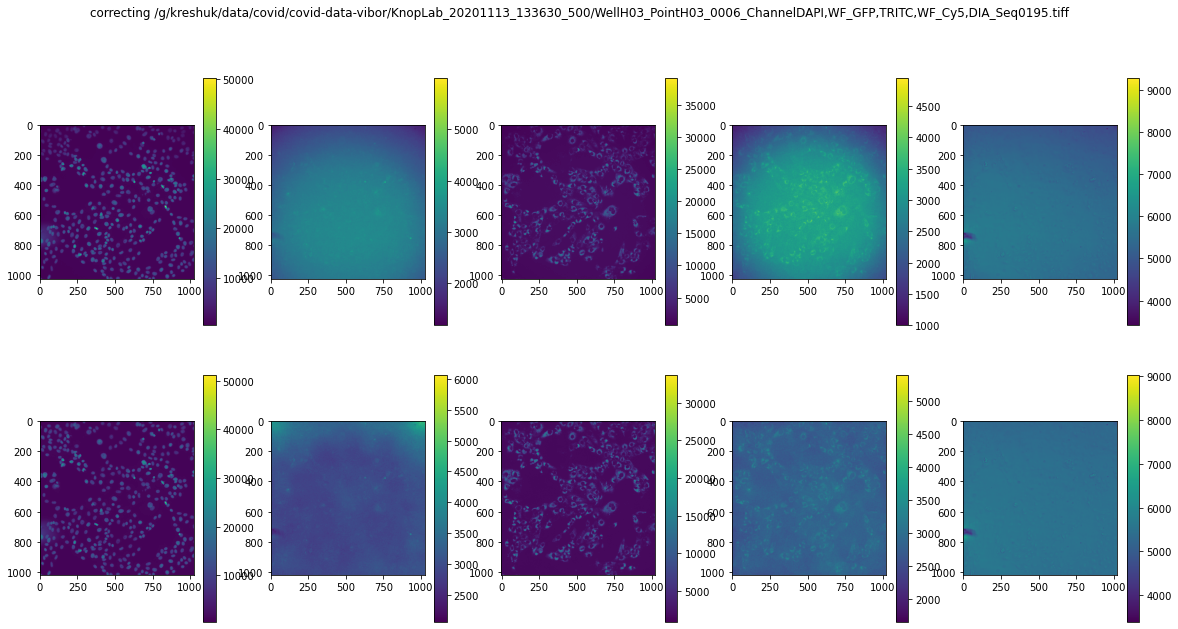

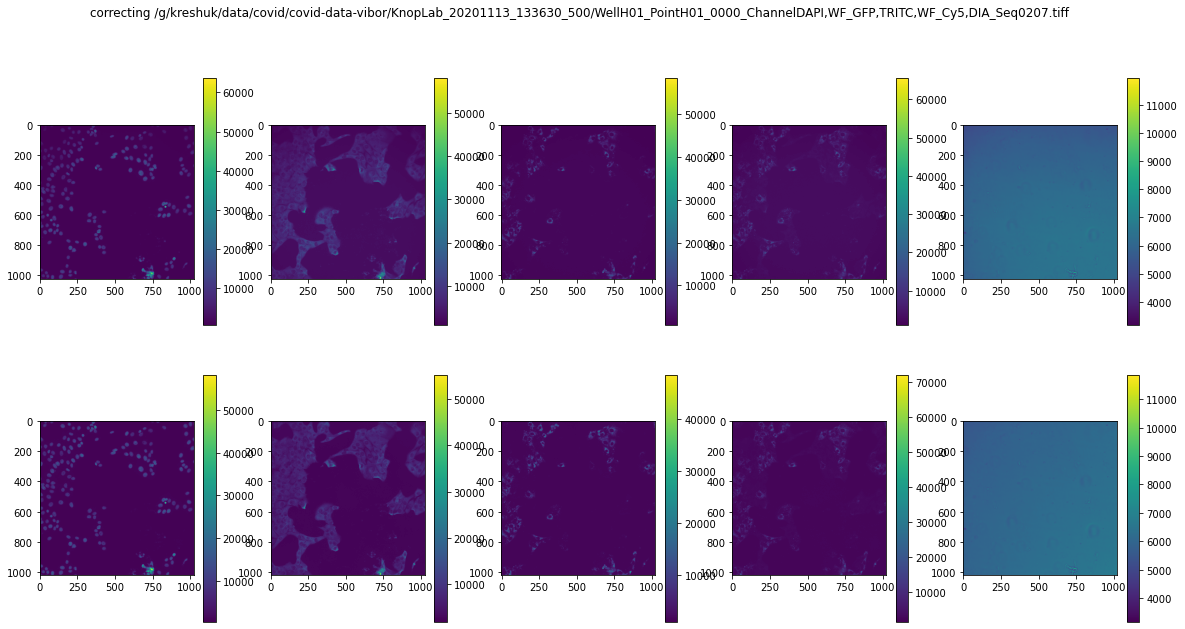

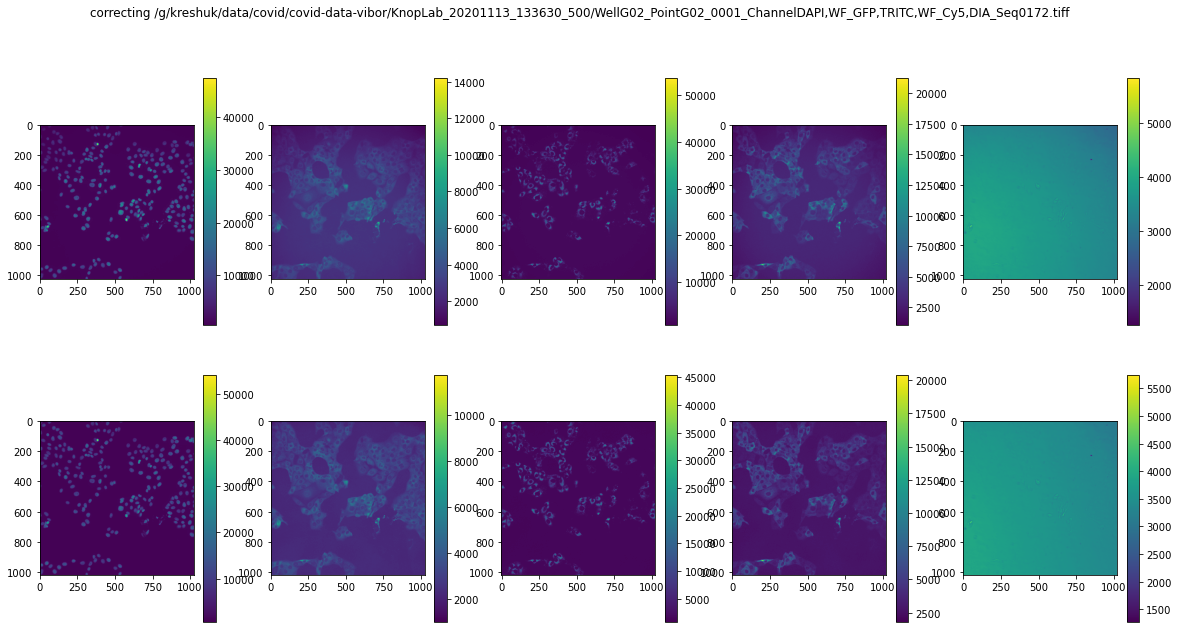

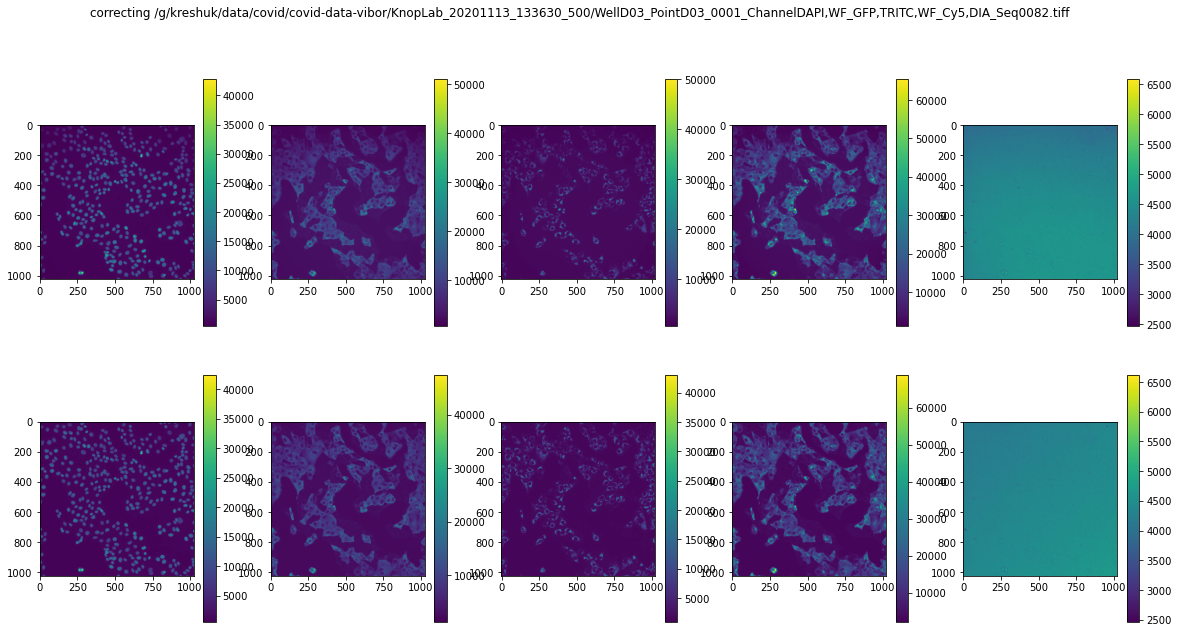

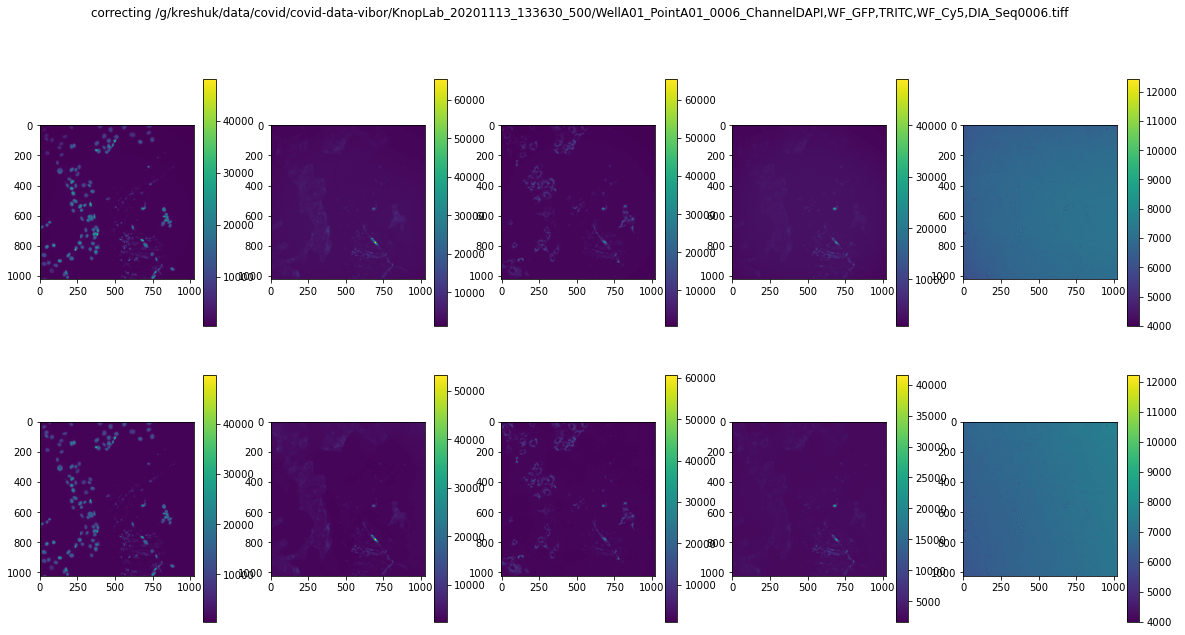

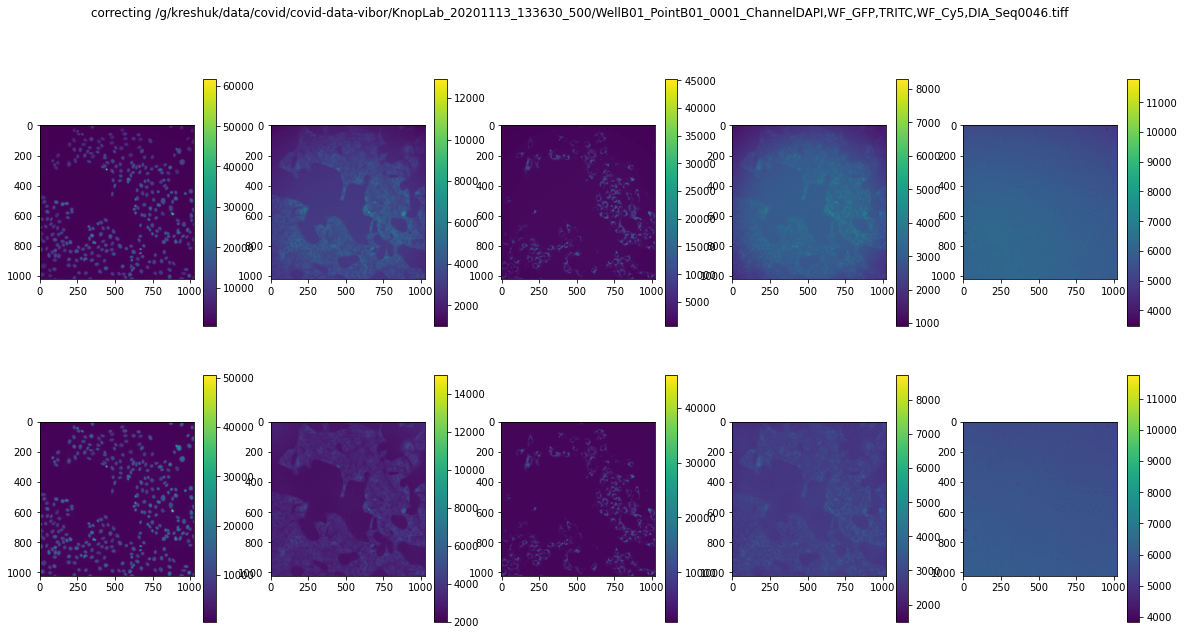

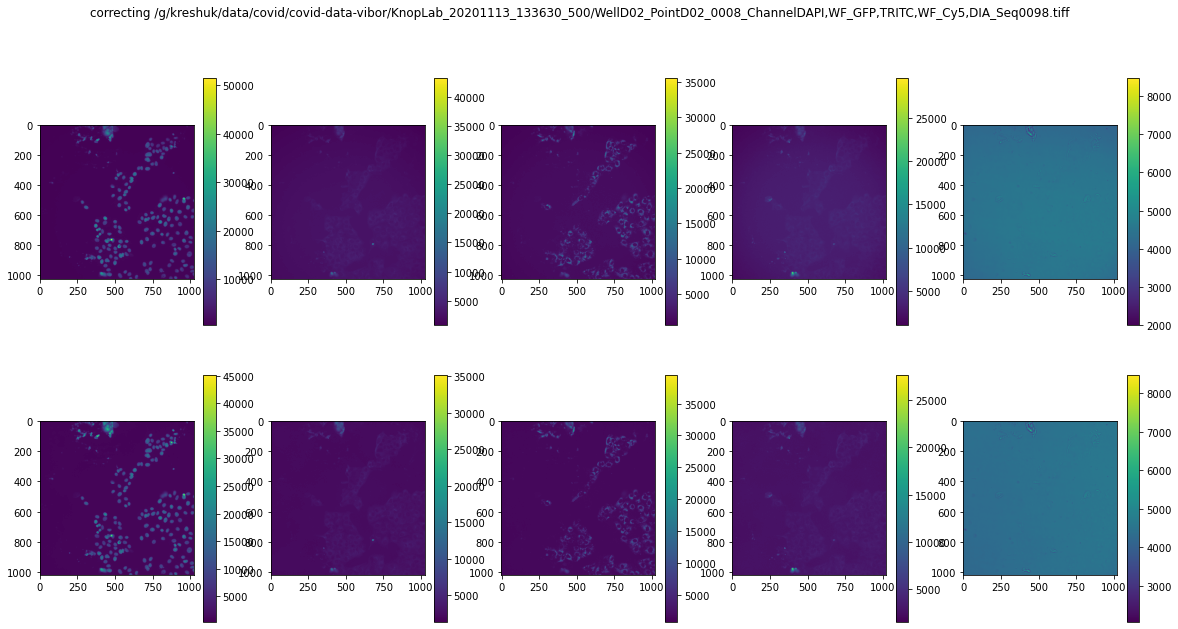

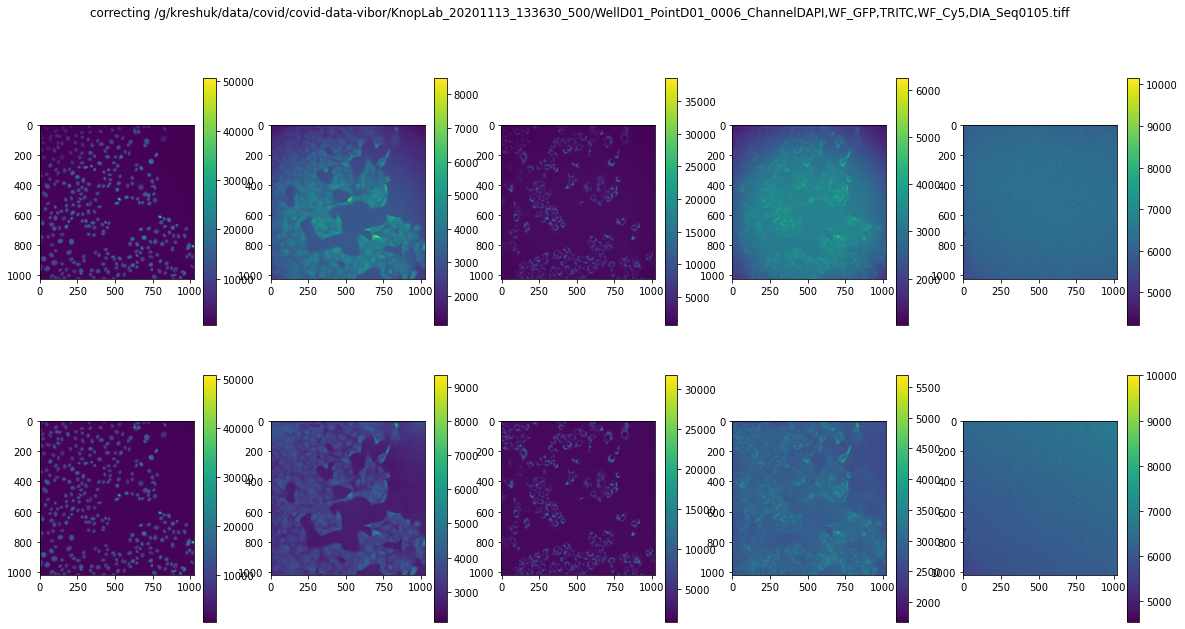

In [35]:
# show 10 random corrections
for f in np.random.choice(files, 10):
    img = tifffile.imread(f)
    # print(img.shape)
    # if img.shape[0] > 3:
    #     img = img[[0, 1, 2]]
    fig, ax = plt.subplots(2, len(channels), figsize=(20, 10))
    for c in range(len(channels)):
        im = ax[0, c].imshow(img[c])
        fig.colorbar(im, ax=ax[0, c])
        
        channel = channels[c]
        corrected = barrel_correct(img[c], meta_avg_dict[channel])
        im = ax[1, c].imshow(corrected)
        fig.colorbar(im, ax=ax[1, c])
    
    plt.suptitle(f'correcting {f}')
    plt.show()